This program demonstrates feature engineering for my project.
Reinforcement learning will be applied to the task of finding the most efficient route between multiple locations.

What is TSP:
For the following explanation of TSP, allow for:
    n = Total Number of Locations
    P(n) = Total Number of Permutations of Locations
    
Due to P(n) growing exponentially as n grows linearly, many traditional computers cannot handle the task of finding the most efficient route using conventional means (i.e., calculating the parameters for each permutation). This becomes the case at a relatively low number when compared to the amount of mail distributed daily within each US city. In fact, n=75 has more permutations than the largest estimation of atoms within the observable universe (2.4809140811395E+109 versus 10E+82, respectively).

One solution to this problem (implemented by UPS) is to cluster the locations into groups of five and calculate the quickest route for each cluster, then clustering the clusters by the same manner (by five) and calculating the quickest route between them. This will continue until the total amount of combined clusters is less than or equal to five, and finally they are all combined. This approach minimizes the number of calculations necessary to find a suitable route, though it does not find the most efficient route. As a consequence of clustering locations, this algorithm fails to account for the possibility of more efficient routes that travel outside the boundaries set by the lowest-level clusters.

As a solution to this problem, I will be applying the capabilities of reinforcement learning. I believe this approach is suitable to the problem because there is a lack of real-world training data to support most supervised training methodologies.

I am attempting to create a class that holds all the attributes and features of the spatial data. My goal will to be to optimize each process to the best of my knowledge so that the model won't be hindered by poor performance. I have decided to use randomly generated points for houses and gas stations. However, the method of generating them randomly is different. For houses, I generate random coordinates within the polygon and locate the nearest node to each random point within the street network that falls within the polygon. This is to simulate 'mail stops', as a mail-delivery agent would likely have multiple houses to visit during many of the planned stops within a route. In this case, the random points would be houses and the nearest nodes would be where the mail-delivery agent stops their vehicle to deliver the mail. For gas stations, I randomly select n nodes within the street network to represent a gas station at some intersection. Also, road speed limits are approximated using averages based on road type. It's important to keep in mind that the goal is not to produce an environment which perfectly emulates real-life; rather, the goal is to create a solution to TSP which can be adapted to real life situations.



Class poly_pocket()

In [7]:
import numpy as np
import geopandas as gpd
import random
import osmnx as ox
from math import radians
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import LineString


class poly_pocket():   
    '''
    My hope is to create a class that can store instances 
    of spatial data for a machine learning model to use.
    poly_pocket was designed to create an instance of a
    polygon and hold all the polygons data, hence the name.
    
    params:    center = a coordinate location formated in (lon, lat)
               dist = distance from center in meters as radius
    '''
    def __init__(self, center, dist, crs='epsg:4326'):    
        '''
        self.__named~ attributes serve as subclasses similar to named tuples
        Using self.retrieve(key, source), a model can pull the data from these
        dictionary attributes.
        '''
        # Defines attributes for the center point
        self.__centeroid = Point(center)
        self.__center_gdf = gpd.GeoDataFrame([self.__centeroid], columns=['geometry'], crs=crs)
        
        # Defines the buffered shape
        self.__gdf = self.__center_gdf.to_crs('+proj=aeqd +units=m  +x_0=0 +y_0=0')
        self.__gdf = self.__gdf['geometry'].buffer(dist).to_crs(crs)
        
        # Defines attributes for the buffered shape boundaries
        self.__minx, self.__miny, self.__maxx, self.__maxy = [self.__gdf.bounds[bound] for bound in self.__gdf.bounds]
        
        # Holds named groups of attributes, each value sharing an index by key across the dicts
        self.__named_points = dict() # {key, array(randomly generated points)}
        self.__named_neares = dict() # {key, array(nearest real node)}
        self.__named_connec = dict() # {key, array(linestrings connecting neighbors)}
        self.__named_rnodes = dict() # {key, array(randomly sampled nodes)}
        self.__named_osmids = dict() # {key, index(osmids)}
        
    
    # Returns center point of polygon
    def center(self):
        return center
    
    # Returns distance used to buffer center
    def dist(self):
        return dist
    
    # Returns a GeoDataFrame of the polygon
    def gdf(self):
        return self.__gdf
    
    
    # Provides ability to request data from dict attributes
    def retrieve(self, identifier, source=[], as_gdf=True):
        '''
        Queries self.__named_~ for spatial data. By default returns
        a GeoDataFrame, but as_gdf=False will return raw iterables
        
        Source must be a list and may contain the following:
        ['points', 'neighbors', 'connections', 'rnodes']
        
        param:    identifier = The lookup name
                  source = the lookup location
                  as_gdf = Specify if return should be GeoDataFrame
                  
        return:   A dictionary with identifier_source for keys and a 
                  GeoDataFrame or iterable for values
        '''
        deliverable = dict()
        osm_compatibles = ('neighbors', 'rnodes')
        
        # Appends values to returned dict if requested or by default
        if 'points' in source:
            deliverable.update({f'{identifier}_points':self.__named_points.get(identifier)})
        if 'neighbors' in source:
            deliverable.update({f'{identifier}_neighbors':self.__named_neares.get(identifier)})
        if 'connections' in source:
            deliverable.update({f'{identifier}_connections':self.__named_connec.get(identifier)})
        if 'rnodes' in source:
            deliverable.update({f'{identifier}_rnodes':self.__named_rnodes.get(identifier)})
            
        if as_gdf:
            for key in deliverable.keys():
                # Identifies source and identifier within key
                location = key.split('_')[-1]
                identity = key[:-len(location)-1]
                
                # Checks keys for gdf compatible identifiers
                if location in osm_compatibles:
                    # Updates value to the GDF generated by matching osmids in index of street nodes
                    gdf = self.__nodes.loc[self.__named_osmids.get(identity)]
                    deliverable.update({key:gdf})
                else:
                    # Converts array into GDF
                    gdf = gpd.GeoDataFrame(deliverable.get(key), columns=['geometry'])
                    deliverable.update({key:gdf})
            
        return deliverable

    
    def rand_points(self, identifier, n_points, crs='epsg:4326', return_points=False):       
        points = []
        
        # Generates random points within polygon
        while len(points) < n_points:         
            random_point = Point([random.uniform(self.__minx, self.__maxx), 
                                  random.uniform(self.__miny, self.__maxy)])
            # Verifies points in bounds
            if (random_point.within(self.__gdf[0])):
                points.append(random_point)

        self.__named_points.update({identifier:points})
        self.__named_neares.update({identifier:None})
        self.__named_connec.update({identifier:None})
     
        return (points if return_points else None)
    
    
    # Queries for the street network within the polygon
    def graph(self, return_graph=False):
        try:
            self.__G       
        except AttributeError: 
            # Queries for graph, travel speeds, travel times
            self.__G = ox.graph_from_polygon(self.__gdf[0], network_type='drive_service')
            self.__G = ox.speed.add_edge_speeds(self.__G)
            self.__G = ox.speed.add_edge_travel_times(self.__G)
            
            self.__nodes, self.__edges = ox.graph_to_gdfs(self.__G, nodes=True, edges=True)
            
        return (self.__G if return_graph else None)
    
    
    # Returns the street network's nodes and edges
    def network_gdf(self): 
        try:
            self.__G
        except AttributeError:
            self.graph()
        
        return (self.__nodes, self.__edges)
    
    
    # Generates array of random nodes taken from street network
    def rand_nodes(self, identifier, n, return_nodes=False):
        try:
            self.__nodes
        except AttributeError:
            self.graph()
        
        # Samples nodes GeoDataFrame
        rand_nodes = self.__nodes.sample(n=n)['geometry']
        
        # Collects attribute dict values
        rand_nodes_arr = rand_nodes.to_numpy()
        rand_nodes_osmids = rand_nodes.index
        
        self.__named_points.update({identifier:rand_nodes_arr})
        self.__named_osmids.update({identifier:rand_nodes_osmids})
        
        return (rand_nodes_arr if return_nodes else None)
    
    
    # Returns the nearest node to each random point
    def nearest_nodes(self, identifier, return_neighbors=False):
        try:
            self.__G
        except AttributeError:
            self.graph()
        
        # Indexes coordinates for point attributes x, y
        coordinates = np.array([(point.y, point.x) for point in self.__named_points.get(identifier)])
        longitudes = coordinates[:,1]
        latitudes = coordinates[:,0]
            
        # Queries nearest nodes in polygon for input coords
        destinations = ox.distance.nearest_nodes(self.__G, longitudes, latitudes) 
        
        # Collects attribute dict values
        nearest_neighbors = self.__nodes.loc[destinations]['geometry']
        nearest_neighbors_arr = nearest_neighbors.to_numpy()
        nearest_neighbors_osmids = nearest_neighbors.index
        
        # Creates linestrings between random points and their nearest nodes
        x = zip(self.__named_points.get(identifier), nearest_neighbors_arr)
        connections = list(LineString([rand_point, nearest_real]) for rand_point, nearest_real in x)
        
        self.__named_neares.update({identifier:nearest_neighbors_arr})
        self.__named_connec.update({identifier:connections})
        self.__named_osmids.update({identifier:nearest_neighbors_osmids})

        return (nearest_neighbors_arr if return_neighbors else None)

Creating an instance

In [2]:
center = (-121.885254, 37.335796)
dist = 1000 # Meters

# Creates polygon with given dimensions
poly = poly_pocket(center, dist)

Instructing the instance

In [3]:
n_points = 60 # Houses
n_nodes = 5 # Gas stations

# Instructs class to generate random coordinate points within polygon
poly.rand_points('houses', n_points)

# Instructs class to query for street network in polygon
poly.graph()

# Instructs class to discover the nearest street
poly.nearest_nodes('houses')

# Instructs class to generate a group of random nodes named 'gas_stations'
poly.rand_nodes('gas_stations', n_nodes)

Querying for data

In [4]:
# Queries for the generated house data and assigns it
source = ['points', 'neighbors', 'connections']
results = poly.retrieve('houses', source=source)
houses_points, houses_neighbors, houses_connections = results.values()

# Queries for the generated gas station data and assigns it
source = ['rnodes']
results = poly.retrieve('gas_stations', source=source)
gas_stations = list(results.values())[0]

Visualizing the data

<AxesSubplot: >

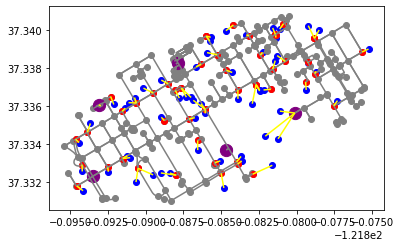

In [5]:
# Plots houses
ax = houses_points.plot(color='blue')

# Plots street network
road_network = poly.network_gdf()
nodes, edges = road_network

nodes.plot(ax=ax, color='grey')
edges.plot(ax=ax, color='grey')

# Plots nearest nodes to each house
houses_neighbors.plot(ax=ax, color='red')

# Plots connections to visually represent neighbors
houses_connections.plot(ax=ax, color='yellow')

# Plots gas stations
gas_stations.plot(ax=ax, color='purple', markersize=150)

As the plot demonstrates, there are five purple gas stations and all the points representing houses have been tethered to a location for the deliveryman to stop at. I should now be able to generate several pockets of generated data, each one with new features to create routes from.